# Q Learning

## Spring mass system
Maximize the mass compression

 10%|▉         | 983/10000 [00:04<00:19, 465.97it/s]

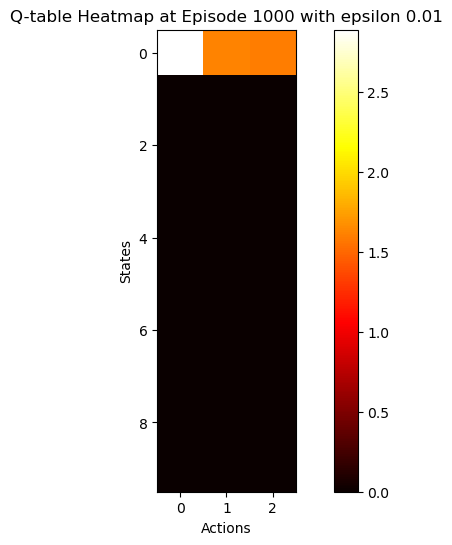

 20%|█▉        | 1959/10000 [00:06<00:15, 504.80it/s]

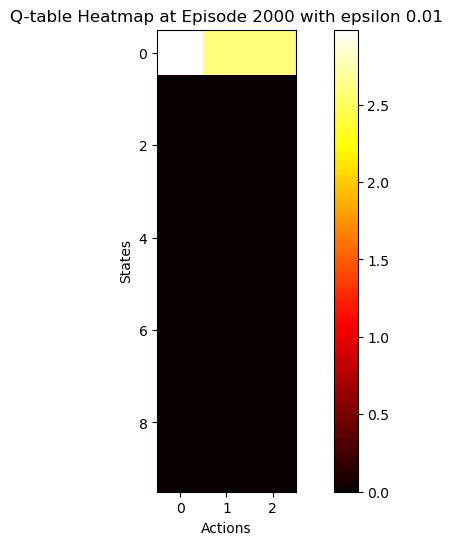

 30%|██▉       | 2993/10000 [00:08<00:14, 497.18it/s]

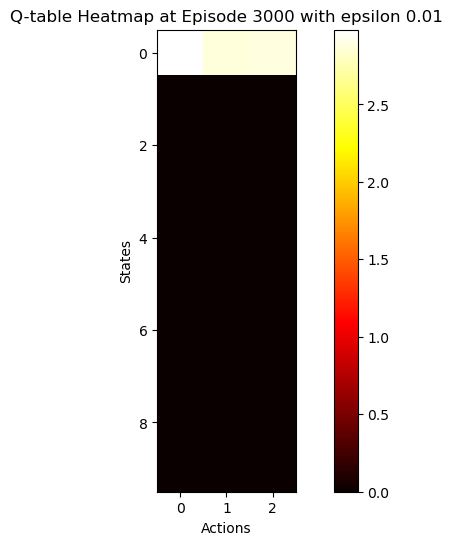

 40%|███▉      | 3971/10000 [00:10<00:12, 496.38it/s]

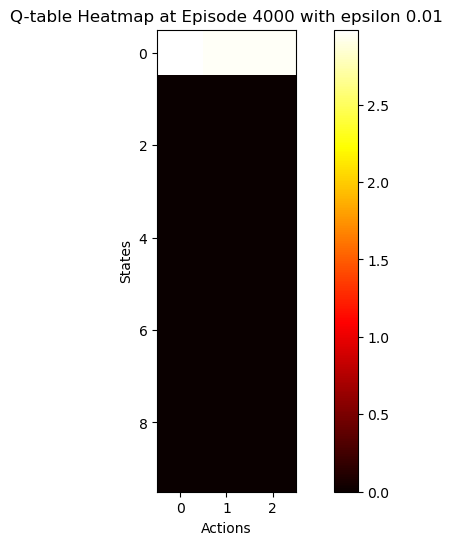

 50%|████▉     | 4951/10000 [00:12<00:10, 477.91it/s]

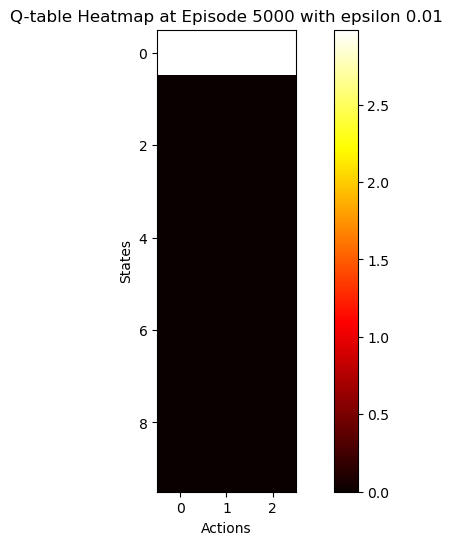

 60%|█████▉    | 5977/10000 [00:14<00:08, 502.27it/s]

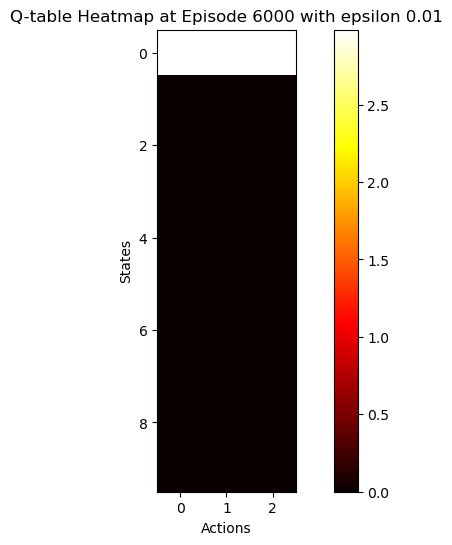

 70%|██████▉   | 6953/10000 [00:16<00:06, 497.19it/s]

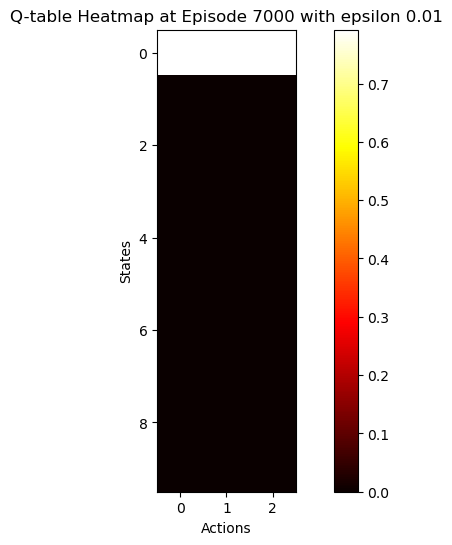

 80%|███████▉  | 7967/10000 [00:18<00:03, 517.94it/s]

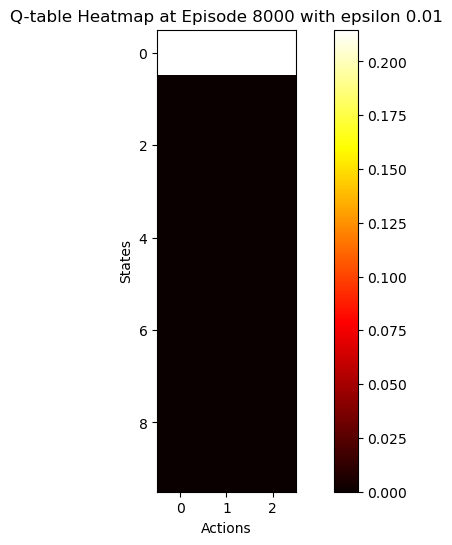

 90%|████████▉ | 8970/10000 [00:20<00:01, 515.57it/s]

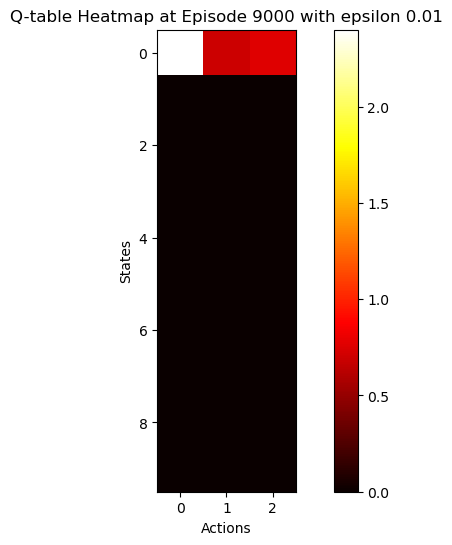

100%|█████████▉| 9990/10000 [00:23<00:00, 508.43it/s]

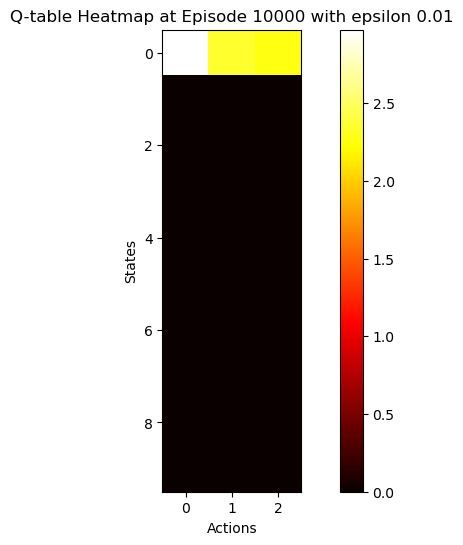

100%|██████████| 10000/10000 [00:25<00:00, 397.11it/s]


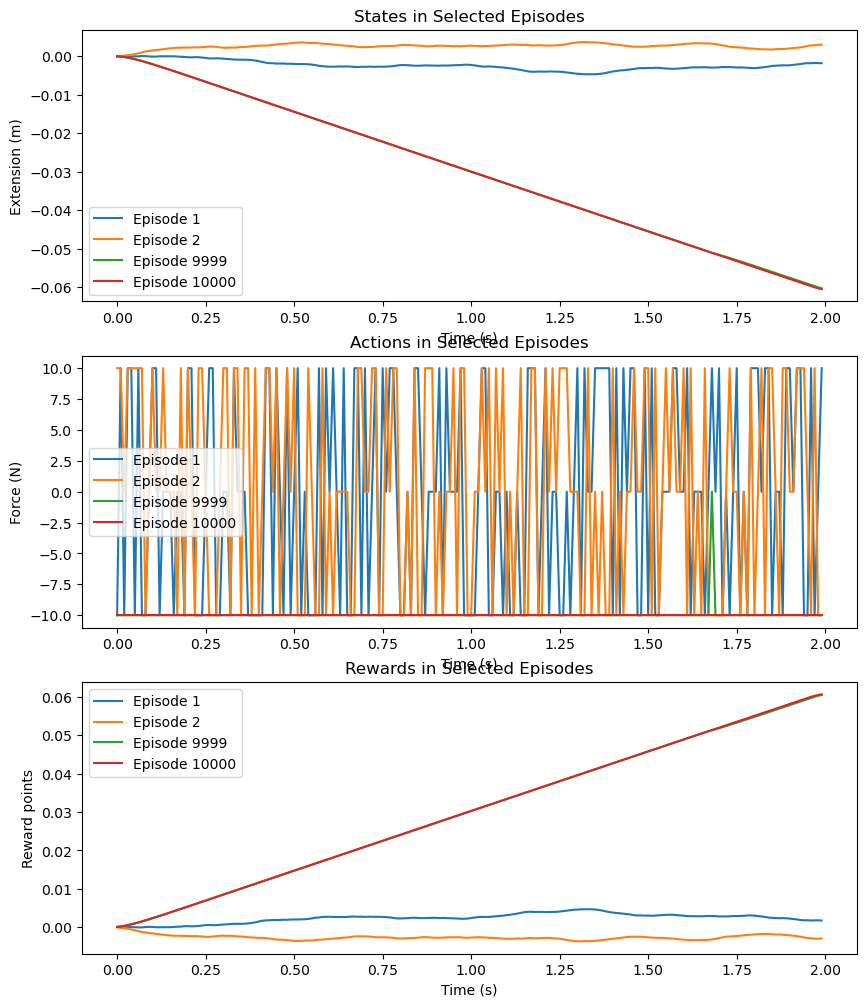

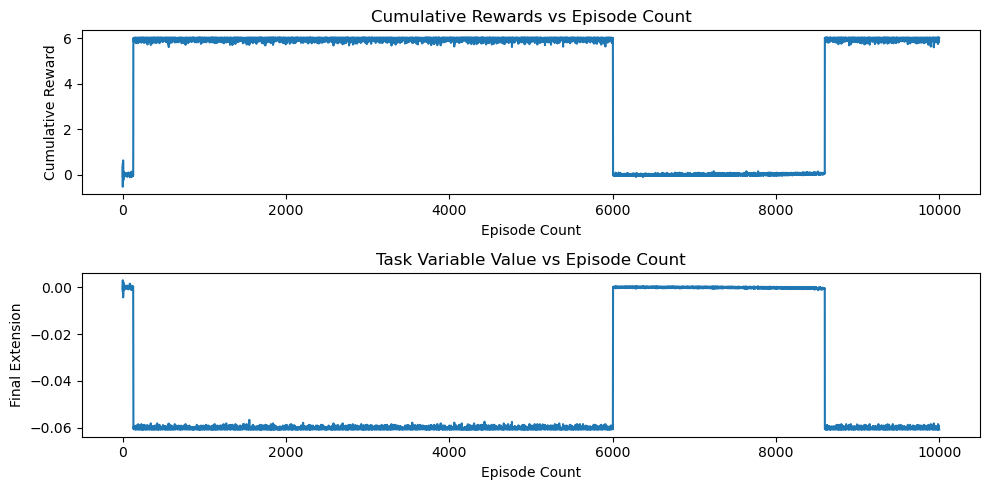

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 200
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.8
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-10, 0, 10]  # Force actions in the environment
EPSILON = 1.0

# Initialize Q-table
Q_table = np.zeros((10, len(ACTIONS)))  # Placeholder for continuous states

# Define constants
WALL_POSITION = -0.1  # The fixed position of the wall (anchor), from the MJCF file


# Define functions
def reset_environment(model, data):
    """Reset the environment and return the natural length (distance between mass and wall)."""
    print(model.qpos_spring)  # Reset the position of the mass
    mujoco.mj_resetData(model, data)  # Reset the simulation
    natural_length = data.qpos[0] - WALL_POSITION  # Initial distance between mass and wall
    return natural_length


def calculate_extension(data, natural_length):
    """Calculate the extension as the distance from the wall minus the natural length."""
    current_length = data.qpos[0] - WALL_POSITION  # Current distance between mass and wall
    return current_length - natural_length  # Extension relative to natural length


def choose_action(state):
    """Choose an action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[int(state)])  # Greedy action


def step_environment(model, data, action, natural_length):
    """Step the environment and return next state (extension), reward, and done."""
    data.ctrl[0] = action  # Apply force as action
    mujoco.mj_step(model, data)  # Step simulation
    extension = calculate_extension(data, natural_length)
    reward = -(extension)  # Task is to minimize the absolute extension
    done = False  # No explicit termination condition for now
    return extension, reward, done


def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)


def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(3, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Extension (m)")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Force (N)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward points")
    plt.legend()
    
    plt.figure(figsize=(10, 5))

    # Plot cumulative rewards
    plt.subplot(2, 1, 1)
    plt.title("Cumulative Rewards vs Episode Count")
    cumulative_rewards = [sum(episode) for episode in episode_rewards]
    plt.plot(range(len(cumulative_rewards)), cumulative_rewards)
    plt.xlabel("Episode Count")
    plt.ylabel("Cumulative Reward")

    # Plot task variable values
    plt.subplot(2, 1, 2)
    plt.title("Task Variable Value vs Episode Count")
    plt.plot(range(len(task_variable_values)), task_variable_values)
    plt.xlabel("Episode Count")
    plt.ylabel("Final Extension")

    plt.tight_layout()
    plt.show()


def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    camera_name = "cam1"
    requested_episodes = {0, 1, EPISODES - 2, EPISODES - 1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []

        # Reset environment and get the natural length
        natural_length = reset_environment(model, data)

        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []

        for step in range(EPISODE_LENGTH):
            extension = calculate_extension(data, natural_length)  # Use extension as the state
            state = extension  # Continuous state (no discretization)

            # Choose action
            action_idx = choose_action(state)
            action = ACTIONS[action_idx]

            # Step the environment
            next_state, reward, done = step_environment(model, data, action, natural_length)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(state)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)

            # Q-learning update
            Q_table[int(state), action_idx] += LEARNING_RATE * (
                reward + GAMMA * np.max(Q_table[int(next_state)]) - Q_table[int(state), action_idx]
            )

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name, options)
                pixel = renderer.render()
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode + 1)}', (10, 30))
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))
                video_frames.append(frame)

            if done:
                break

        # Store episode results
        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qpos[0])  # Store final position of the mass

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)


if __name__ == "__main__":
    main()


 10%|▉         | 989/10000 [00:09<01:06, 135.74it/s]

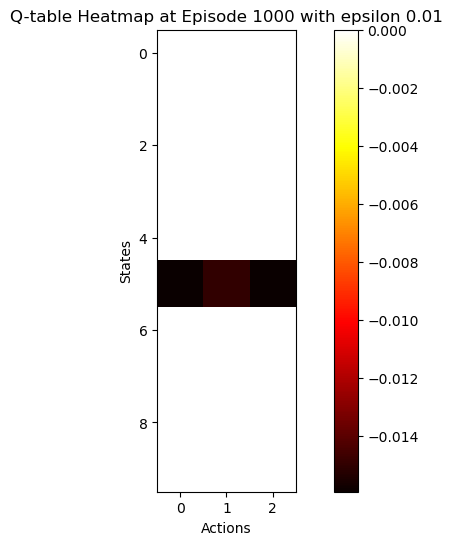

 20%|█▉        | 1984/10000 [00:15<00:51, 155.96it/s]

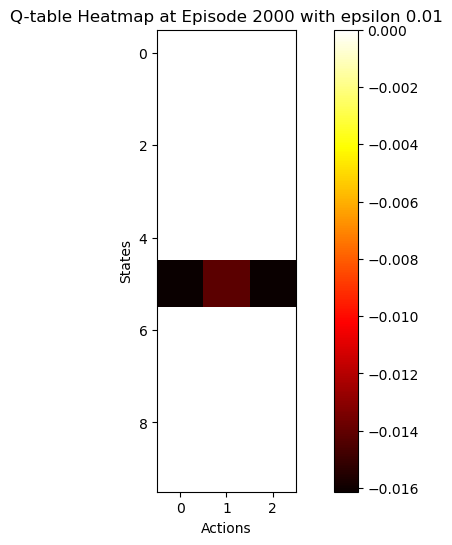

 30%|██▉       | 2987/10000 [00:22<00:44, 157.77it/s]

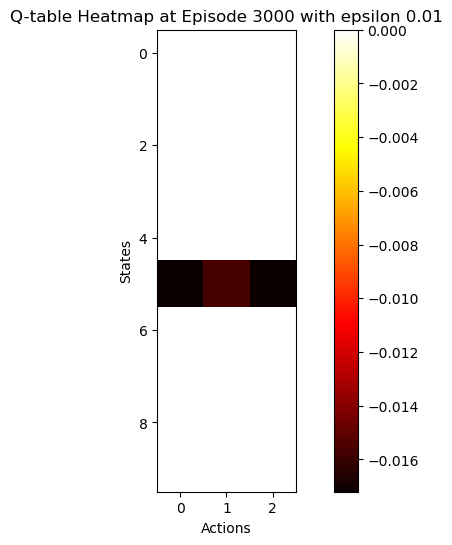

 40%|███▉      | 3994/10000 [00:28<00:37, 158.12it/s]

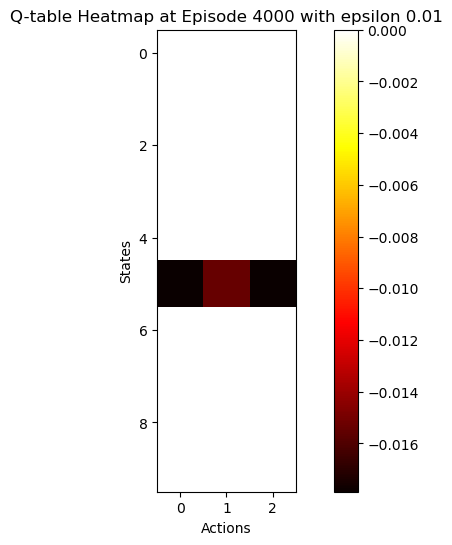

 50%|████▉     | 4986/10000 [00:35<00:32, 155.87it/s]

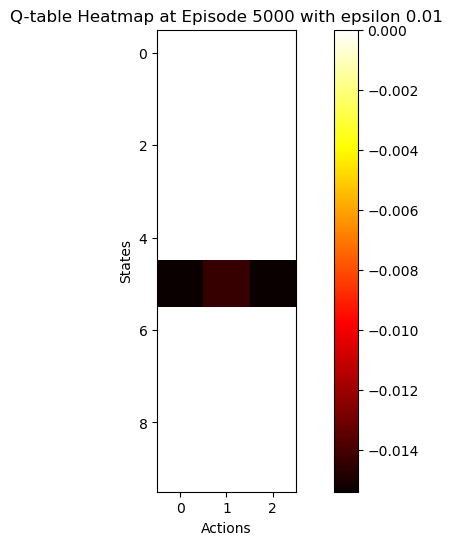

 60%|█████▉    | 5987/10000 [00:42<00:25, 155.99it/s]

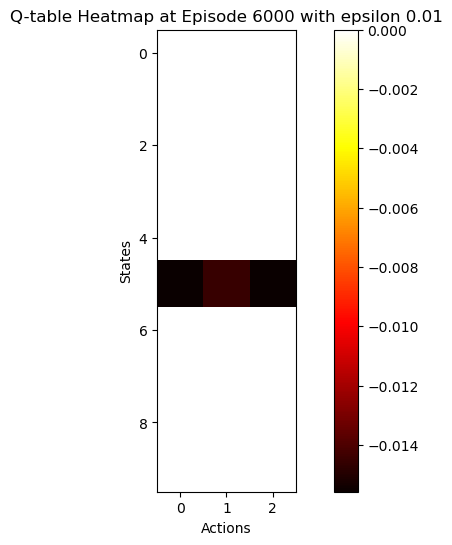

 70%|██████▉   | 6997/10000 [00:48<00:19, 154.83it/s]

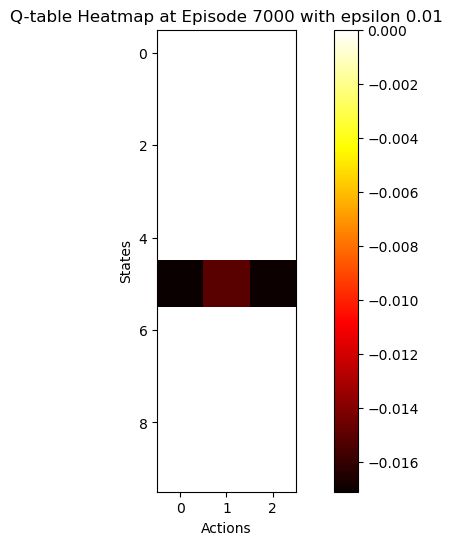

 80%|███████▉  | 7995/10000 [00:56<00:14, 136.29it/s]

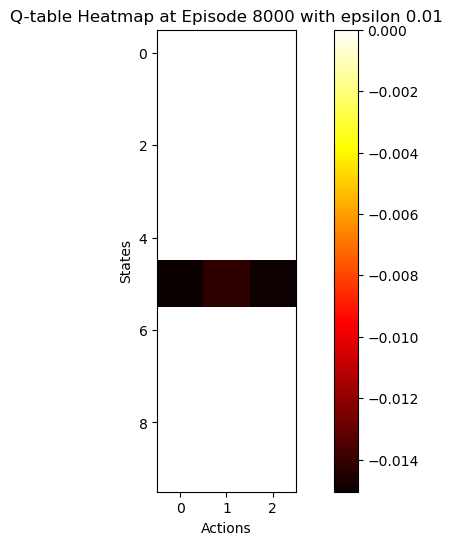

 90%|████████▉ | 8988/10000 [01:02<00:06, 148.52it/s]

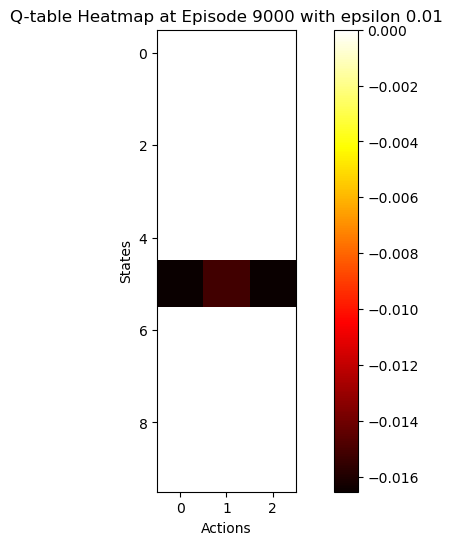

100%|█████████▉| 9997/10000 [01:33<00:00, 28.30it/s] 

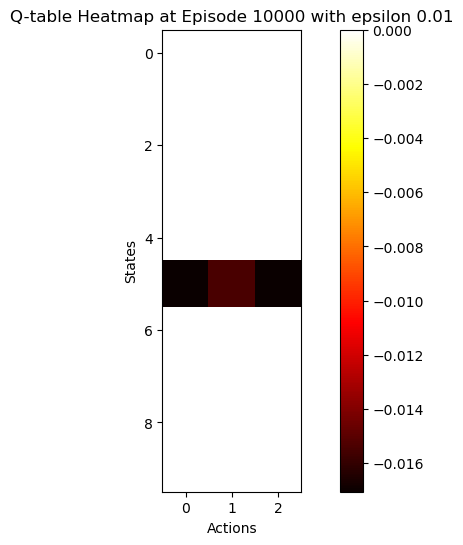

100%|██████████| 10000/10000 [01:38<00:00, 101.98it/s]


IndexError: list index out of range

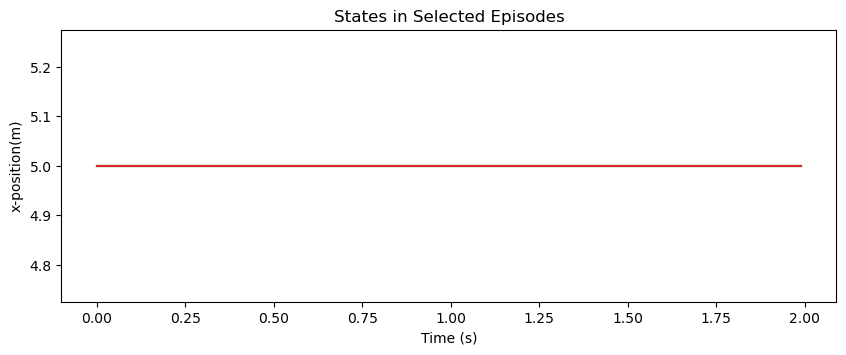

In [14]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 200
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.8
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-10, 0, 10]  # Actions in the environment

# Initialize Q-table and epsilon
Q_table = np.zeros((10, len(ACTIONS)))  # 10 states, 3 actions
EPSILON = 1.0


# Define functions
def discretize_state(state_value):
    """Discretize the continuous state into 10 bins."""
    return int(np.digitize(state_value, np.linspace(-1, 1, 10)))

def choose_action(state):
    """Choose action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[state])  # Greedy action

def step_environment(model,data,action):
    """Step the environment and return next state, reward, done."""
    data.ctrl[0] = action  # Apply force as action
    mujoco.mj_step(model, data)  # Step simulation
    next_state = discretize_state(data.qpos[0])
    reward = -abs(data.qpos[0])  # Task is to minimize distance from zero
    done = False
    return next_state, reward, done

def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(3, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("x-position(m)")
    
    print(state_vars[10000])
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("force (N)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward points")
    plt.legend()
    plt.figure(figsize=(10, 5))
    # Plot for cumulative rewards
    plt.subplot(2, 1, 1)
    plt.title("Cumulative Rewards vs Episode Count")
    cumulative_rewards = [sum(episode) for episode in episode_rewards]
    plt.plot(range(len(cumulative_rewards)), cumulative_rewards)
    plt.xlabel("Episode Count")
    plt.ylabel("Cumulative Reward")

    # Plot for task variable values
    plt.subplot(2, 1, 2)
    plt.title("Task Variable Value vs Episode Count")
    plt.plot(range(len(task_variable_values)), task_variable_values)
    plt.xlabel("Episode Count")
    plt.ylabel("final x-position")

    plt.tight_layout()
    plt.show()

def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    # Rendering setup
    camera_name = "cam1"
    # Define the episodes to render
    requested_episodes = {0, 1, EPISODES-2, EPISODES-1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []  # Store rewards at each step
        # Reset environment
        data.qpos[0] = 0.0
        options = mujoco.MjvOption()
        mujoco.mjv_defaultOption(options)
        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []
        for step in range(EPISODE_LENGTH):
            state = discretize_state(data.qpos[0])
            action_idx = choose_action(state)
            action = ACTIONS[action_idx]

            next_state, reward, done = step_environment(model,data,action)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(state)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)
            # Q-learning update
            Q_table[state, action_idx] += LEARNING_RATE * (reward + GAMMA * np.max(Q_table[next_state]) - Q_table[state, action_idx])

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name,options)
                pixel = renderer.render()
                #frame=pixel
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode+1)}', (10, 30))  # Ensures episode is an integer
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))  # Time with 2 decimal places
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))  # Force with 2 decimal places
                # frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                video_frames.append(frame)
            

            if done:
                break
        
        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        # Store episode results
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qpos[0])  # Store final position of the mass

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)

if __name__ == "__main__":
    main()


 10%|▉         | 996/10000 [00:18<02:17, 65.29it/s]

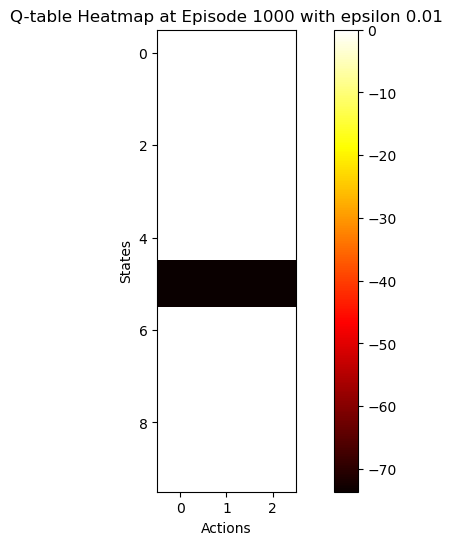

 20%|█▉        | 1998/10000 [00:35<02:46, 48.02it/s]

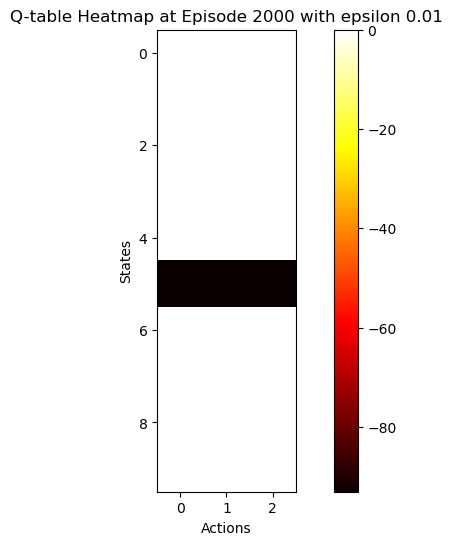

 30%|██▉       | 2994/10000 [00:53<02:12, 52.97it/s]

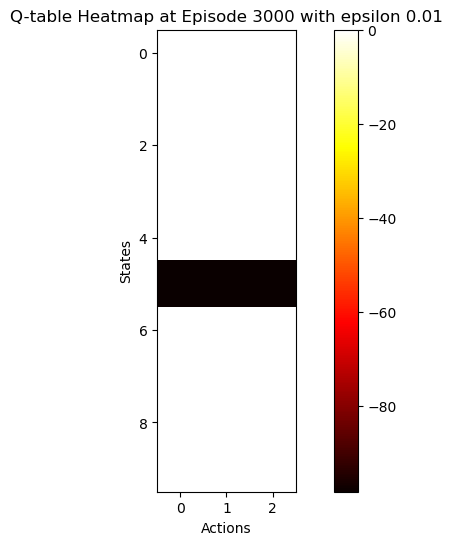

 40%|███▉      | 3997/10000 [01:10<01:58, 50.49it/s]

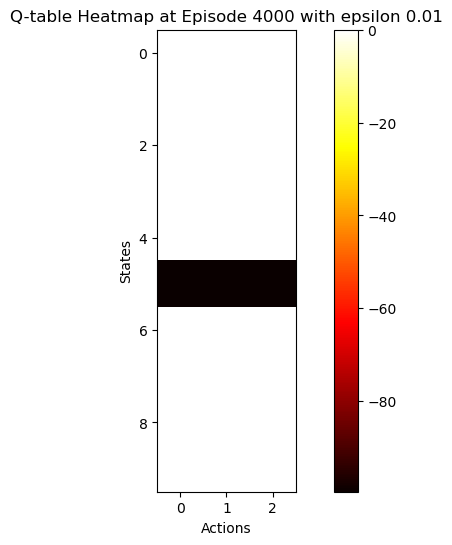

 50%|████▉     | 4993/10000 [01:27<01:03, 78.65it/s]

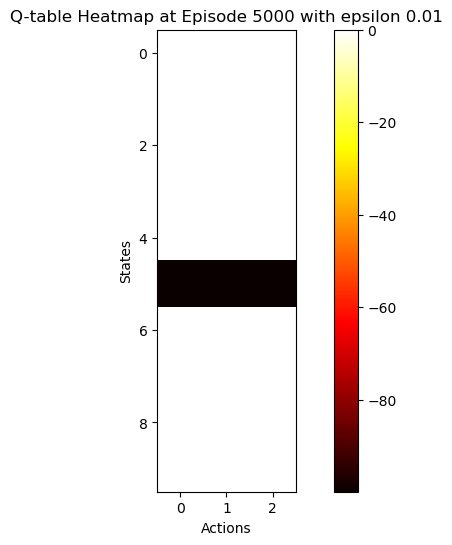

 60%|█████▉    | 5996/10000 [01:44<01:09, 57.40it/s]

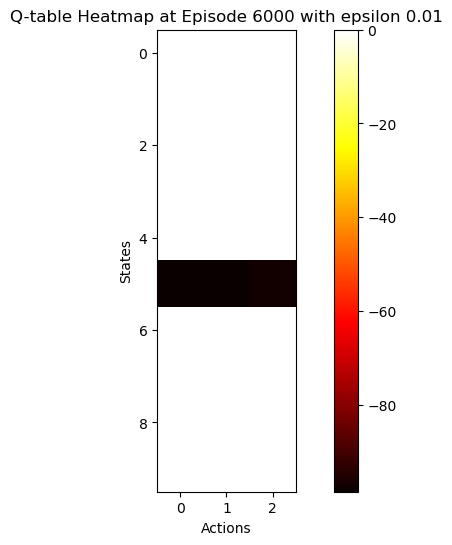

 70%|██████▉   | 6998/10000 [02:00<00:59, 50.87it/s]

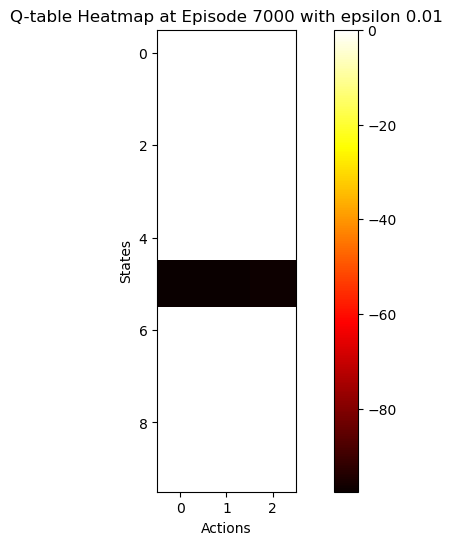

 80%|███████▉  | 7992/10000 [02:18<00:35, 55.92it/s]

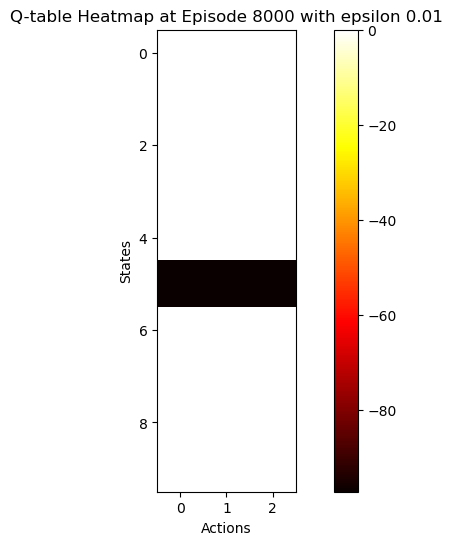

 90%|████████▉ | 8997/10000 [02:35<00:14, 67.64it/s]

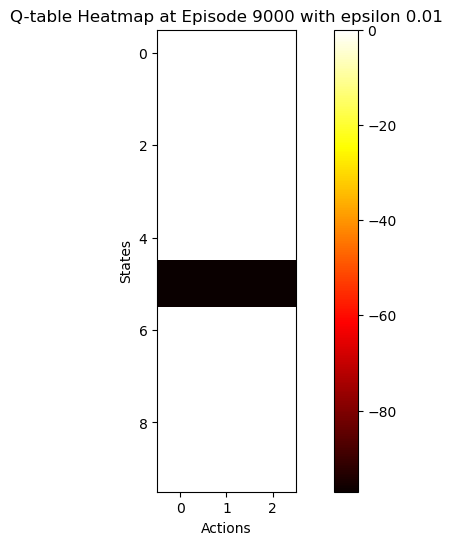

100%|█████████▉| 9999/10000 [02:53<00:00, 11.80it/s]

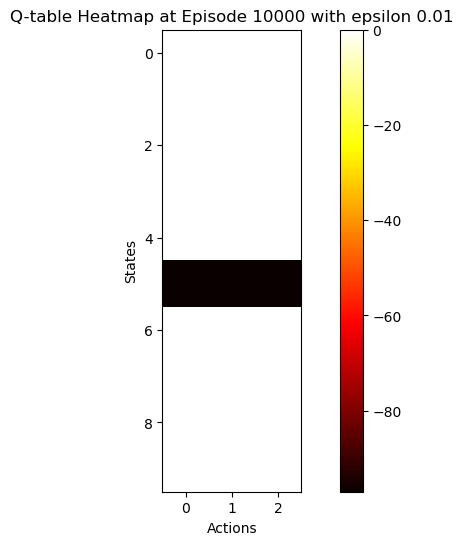

100%|██████████| 10000/10000 [02:55<00:00, 56.99it/s]


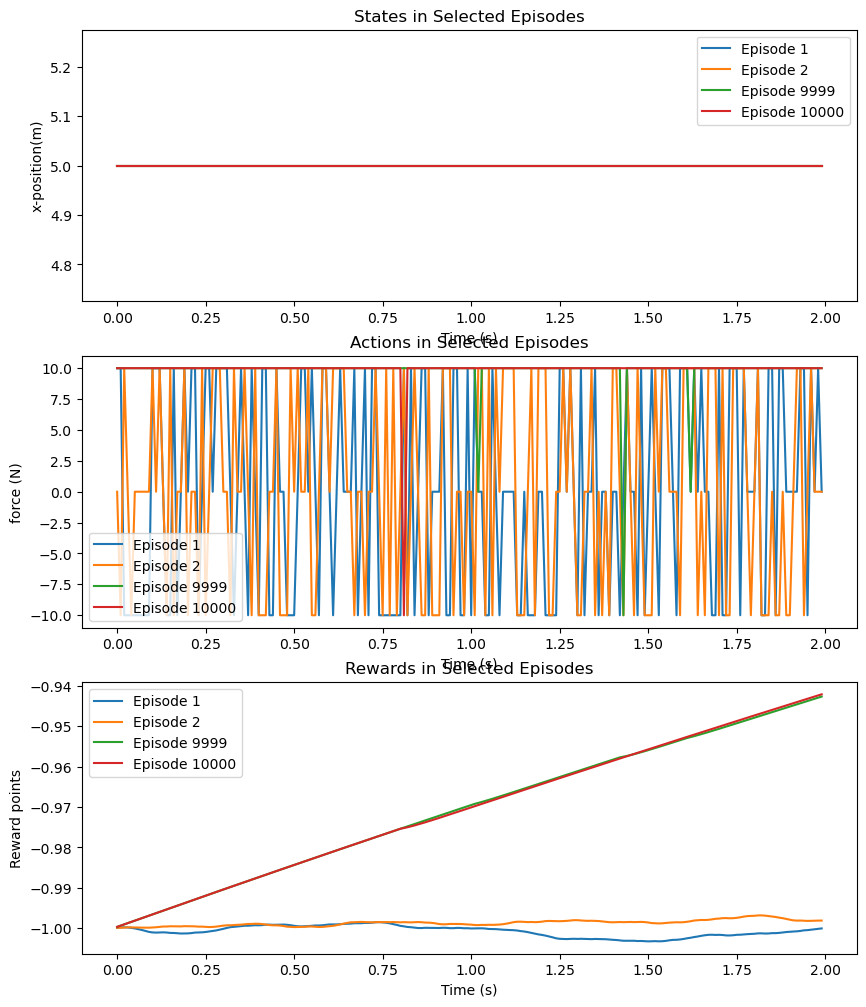

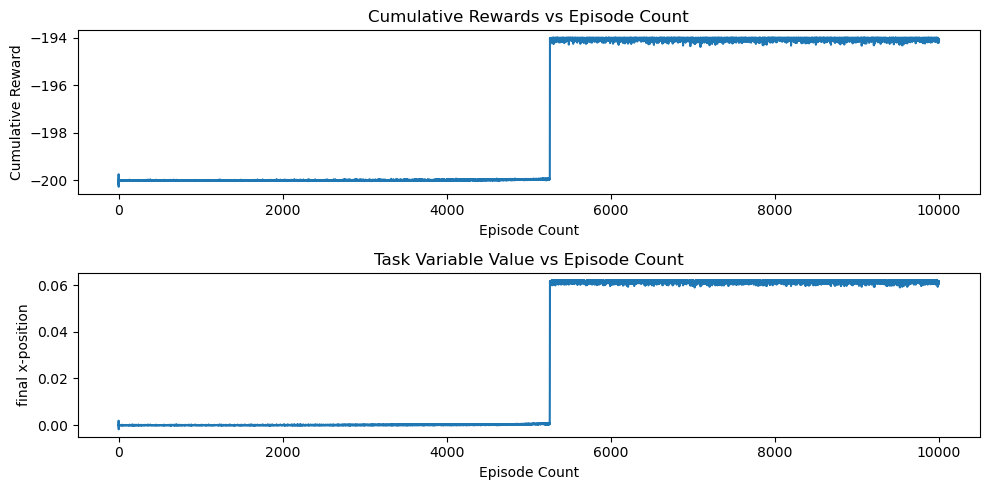

In [10]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 200
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.8
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-10, 0, 10]  # Actions in the environment

# Initialize Q-table and epsilon
Q_table = np.zeros((10, len(ACTIONS)))  # 10 states, 3 actions
EPSILON = 1.0


# Define functions
def discretize_state(state_value):
    """Discretize the continuous state into 10 bins."""
    return int(np.digitize(state_value, np.linspace(-1, 1, 10)))

def choose_action(state):
    """Choose action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[state])  # Greedy action

def step_environment(model,data,action):
    """Step the environment and return next state, reward, done."""
    data.ctrl[0] = action  # Apply force as action
    mujoco.mj_step(model, data)  # Step simulation
    next_state = discretize_state(data.qpos[0])
    reward = -abs(1/(1+data.qpos[0]))  # Task is to minimize distance from zero
    done = False
    return next_state, reward, done

def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(3, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("x-position(m)")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("force (N)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward points")
    plt.legend()
    plt.figure(figsize=(10, 5))
    # Plot for cumulative rewards
    plt.subplot(2, 1, 1)
    plt.title("Cumulative Rewards vs Episode Count")
    cumulative_rewards = [sum(episode) for episode in episode_rewards]
    plt.plot(range(len(cumulative_rewards)), cumulative_rewards)
    plt.xlabel("Episode Count")
    plt.ylabel("Cumulative Reward")

    # Plot for task variable values
    plt.subplot(2, 1, 2)
    plt.title("Task Variable Value vs Episode Count")
    plt.plot(range(len(task_variable_values)), task_variable_values)
    plt.xlabel("Episode Count")
    plt.ylabel("final x-position")

    plt.tight_layout()
    plt.show()

def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    # Rendering setup
    camera_name = "cam1"
    # Define the episodes to render
    requested_episodes = {0, 1, EPISODES-2, EPISODES-1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []  # Store rewards at each step
        # Reset environment
        data.qpos[0] = 0.0
        options = mujoco.MjvOption()
        mujoco.mjv_defaultOption(options)
        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []
        for step in range(EPISODE_LENGTH):
            state = discretize_state(data.qpos[0])
            action_idx = choose_action(state)
            action = ACTIONS[action_idx]

            next_state, reward, done = step_environment(model,data,action)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(state)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)
            # Q-learning update
            Q_table[state, action_idx] += LEARNING_RATE * (reward + GAMMA * np.max(Q_table[next_state]) - Q_table[state, action_idx])

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name,options)
                pixel = renderer.render()
                #frame=pixel
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode+1)}', (10, 30))  # Ensures episode is an integer
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))  # Time with 2 decimal places
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))  # Force with 2 decimal places
                # frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                video_frames.append(frame)
            

            if done:
                break
        
        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        # Store episode results
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qpos[0])  # Store final position of the mass

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)

if __name__ == "__main__":
    main()


 10%|▉         | 995/10000 [00:17<02:21, 63.43it/s]

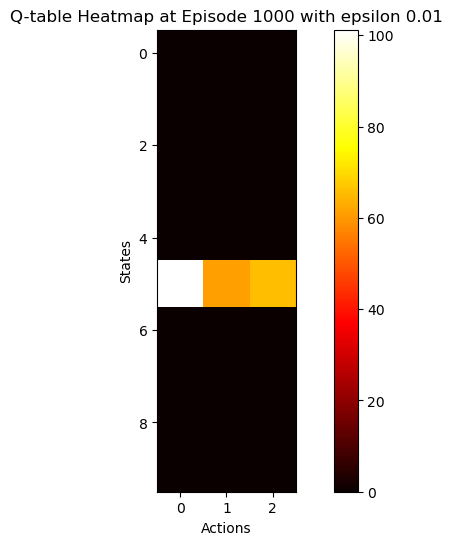

 20%|█▉        | 1993/10000 [00:33<02:03, 64.87it/s]

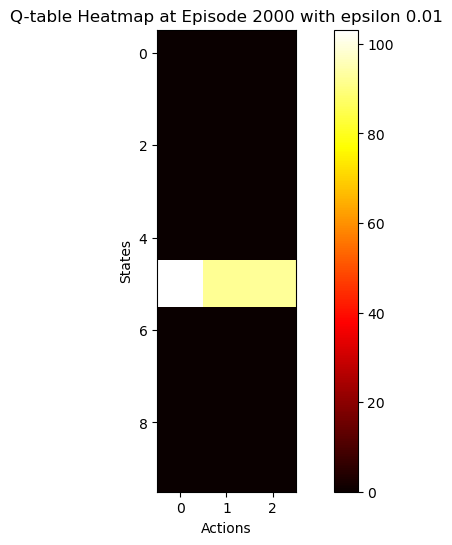

 30%|██▉       | 2991/10000 [00:48<01:12, 96.45it/s] 

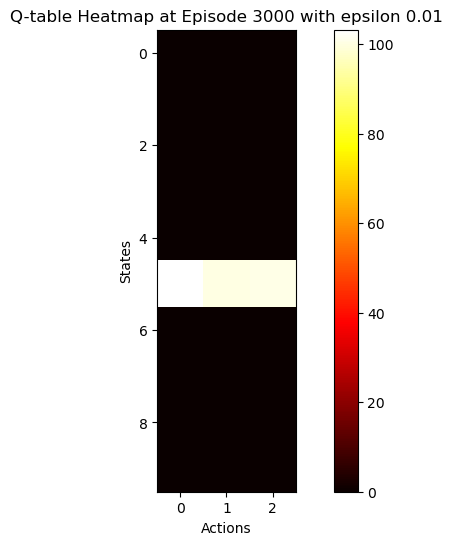

 40%|███▉      | 3994/10000 [00:57<00:40, 149.59it/s]

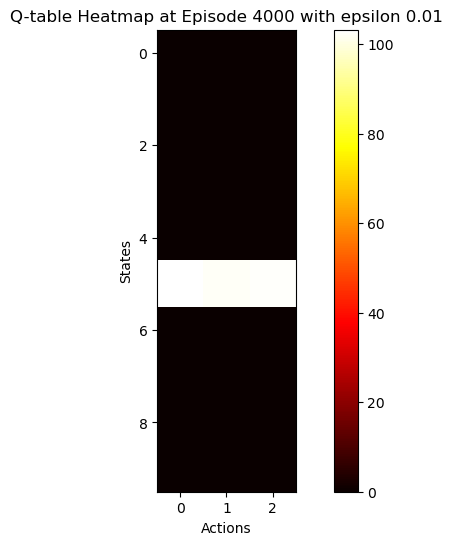

 50%|████▉     | 4985/10000 [01:04<00:33, 149.95it/s]

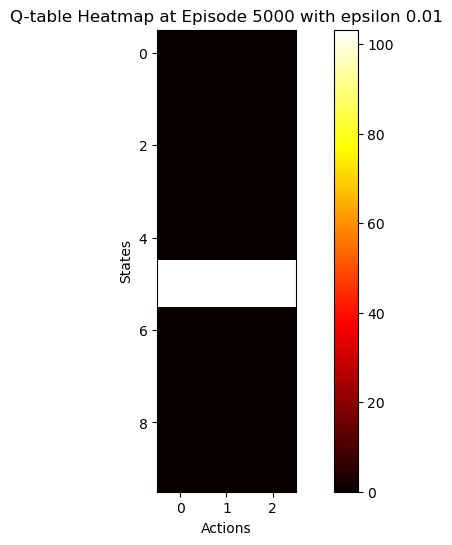

 60%|█████▉    | 5990/10000 [01:11<00:26, 150.59it/s]

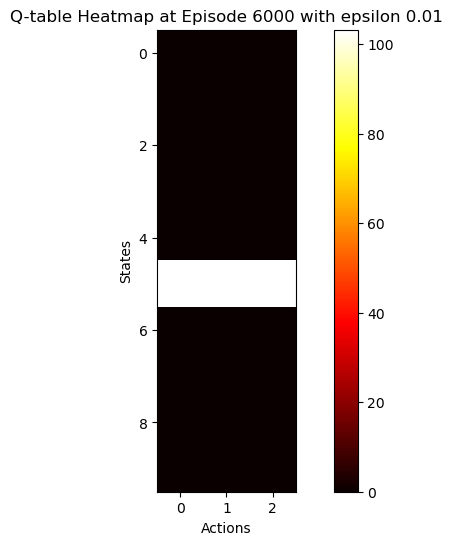

 70%|██████▉   | 6992/10000 [01:17<00:21, 142.36it/s]

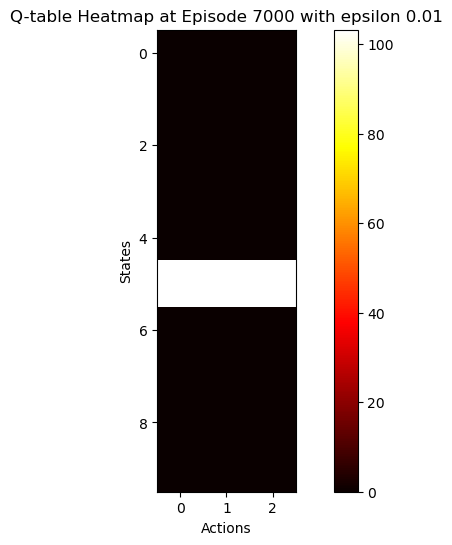

 80%|███████▉  | 7987/10000 [01:24<00:13, 150.70it/s]

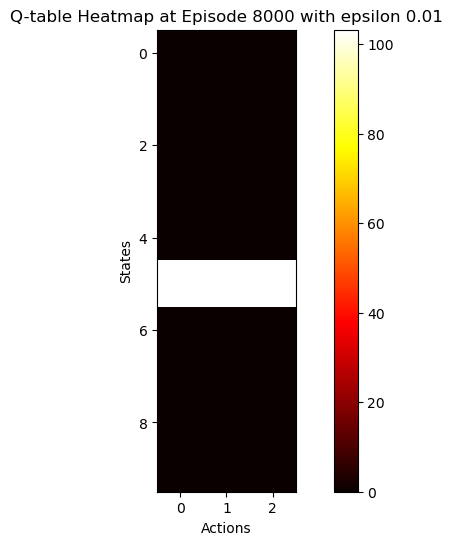

 90%|████████▉ | 8987/10000 [01:31<00:06, 147.44it/s]

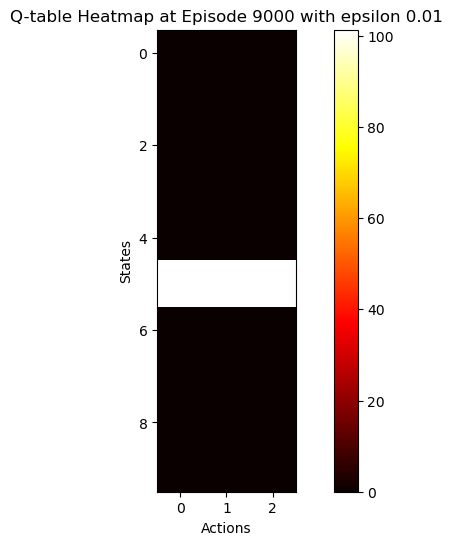

100%|█████████▉| 9992/10000 [01:38<00:00, 145.96it/s]

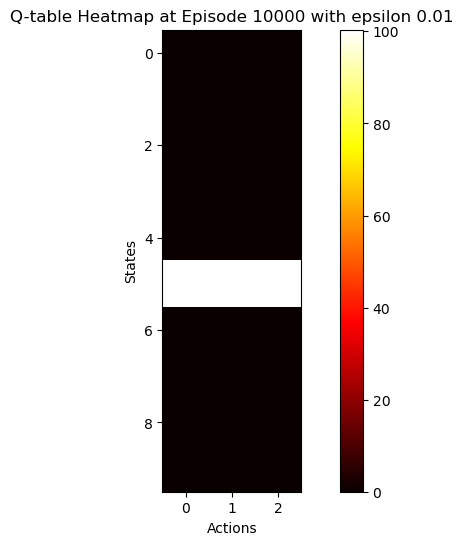

100%|██████████| 10000/10000 [01:41<00:00, 98.83it/s]


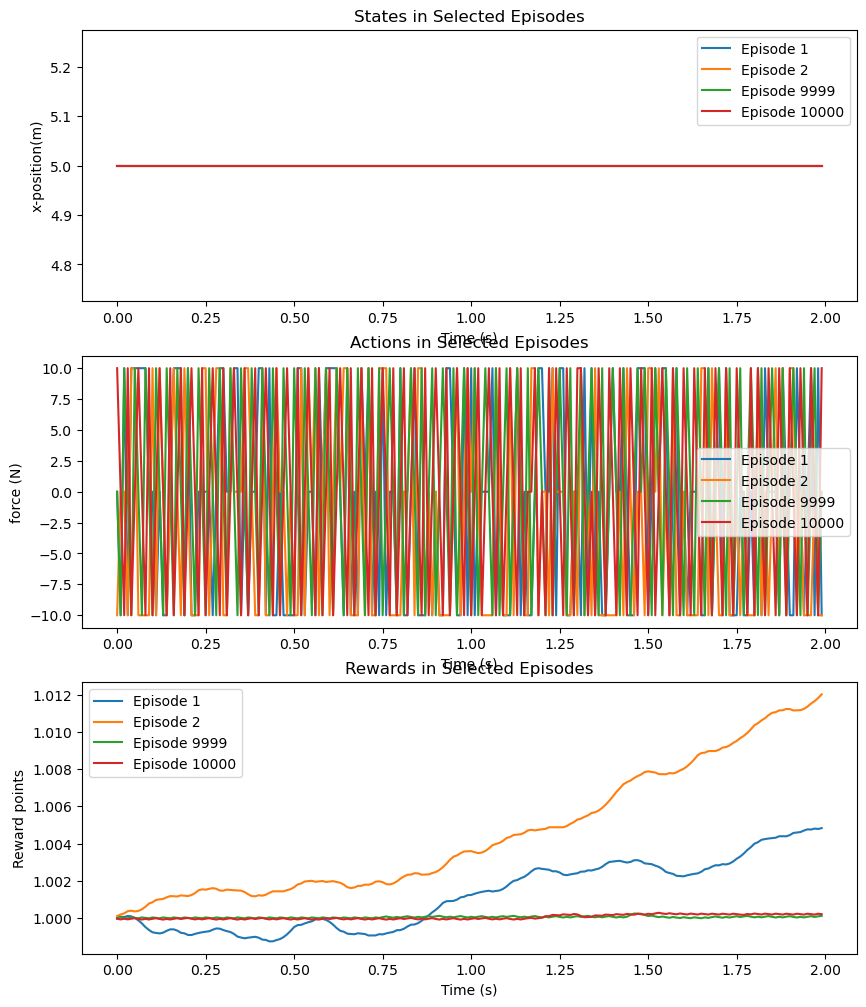

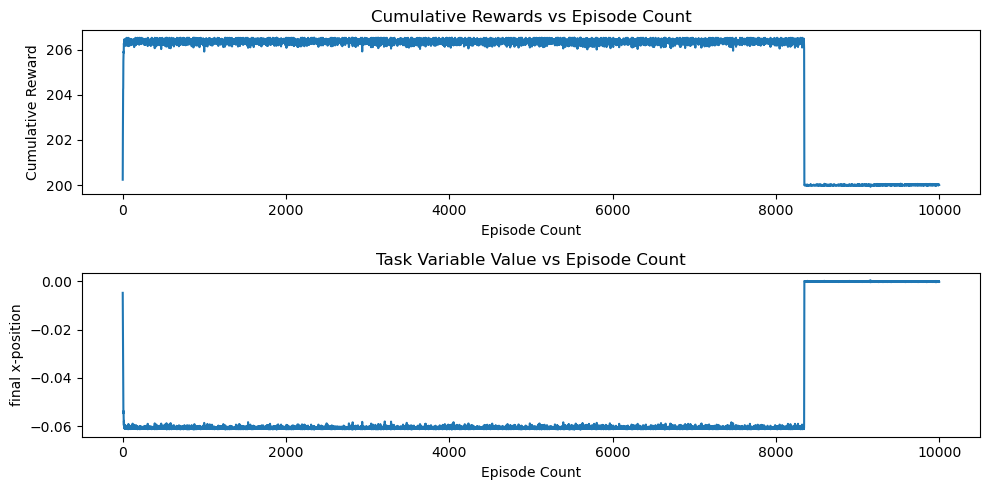

In [11]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 200
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.8
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-10, 0, 10]  # Actions in the environment

# Initialize Q-table and epsilon
Q_table = np.zeros((10, len(ACTIONS)))  # 10 states, 3 actions
EPSILON = 1.0


# Define functions
def discretize_state(state_value):
    """Discretize the continuous state into 10 bins."""
    return int(np.digitize(state_value, np.linspace(-1, 1, 10)))

def choose_action(state):
    """Choose action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[state])  # Greedy action

def step_environment(model,data,action):
    """Step the environment and return next state, reward, done."""
    data.ctrl[0] = action  # Apply force as action
    mujoco.mj_step(model, data)  # Step simulation
    next_state = discretize_state(data.qpos[0])
    reward = abs(1/(1+data.qpos[0]))  # Task is to minimize distance from zero
    done = False
    return next_state, reward, done

def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(3, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("x-position(m)")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("force (N)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward points")
    plt.legend()
    plt.figure(figsize=(10, 5))
    # Plot for cumulative rewards
    plt.subplot(2, 1, 1)
    plt.title("Cumulative Rewards vs Episode Count")
    cumulative_rewards = [sum(episode) for episode in episode_rewards]
    plt.plot(range(len(cumulative_rewards)), cumulative_rewards)
    plt.xlabel("Episode Count")
    plt.ylabel("Cumulative Reward")

    # Plot for task variable values
    plt.subplot(2, 1, 2)
    plt.title("Task Variable Value vs Episode Count")
    plt.plot(range(len(task_variable_values)), task_variable_values)
    plt.xlabel("Episode Count")
    plt.ylabel("final x-position")

    plt.tight_layout()
    plt.show()

def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    # Rendering setup
    camera_name = "cam1"
    # Define the episodes to render
    requested_episodes = {0, 1, EPISODES-2, EPISODES-1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []  # Store rewards at each step
        # Reset environment
        data.qpos[0] = 0.0
        options = mujoco.MjvOption()
        mujoco.mjv_defaultOption(options)
        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []
        for step in range(EPISODE_LENGTH):
            state = discretize_state(data.qpos[0])
            action_idx = choose_action(state)
            action = ACTIONS[action_idx]

            next_state, reward, done = step_environment(model,data,action)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(state)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)
            # Q-learning update
            Q_table[state, action_idx] += LEARNING_RATE * (reward + GAMMA * np.max(Q_table[next_state]) - Q_table[state, action_idx])

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name,options)
                pixel = renderer.render()
                #frame=pixel
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode+1)}', (10, 30))  # Ensures episode is an integer
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))  # Time with 2 decimal places
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))  # Force with 2 decimal places
                # frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                video_frames.append(frame)
            

            if done:
                break
        
        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        # Store episode results
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qpos[0])  # Store final position of the mass

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)

if __name__ == "__main__":
    main()


 10%|▉         | 988/10000 [00:10<01:03, 142.89it/s]

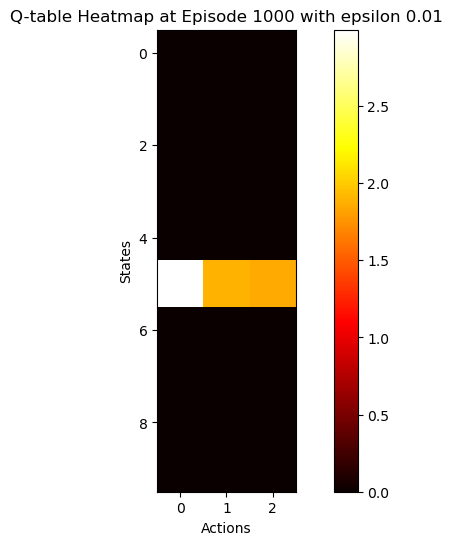

 20%|█▉        | 1988/10000 [00:16<00:54, 147.45it/s]

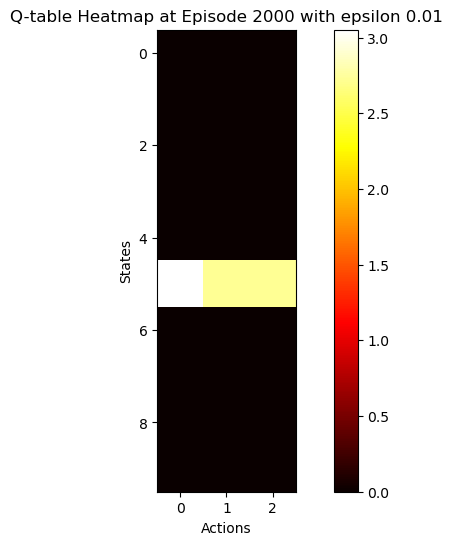

 30%|██▉       | 2991/10000 [00:23<00:47, 146.93it/s]

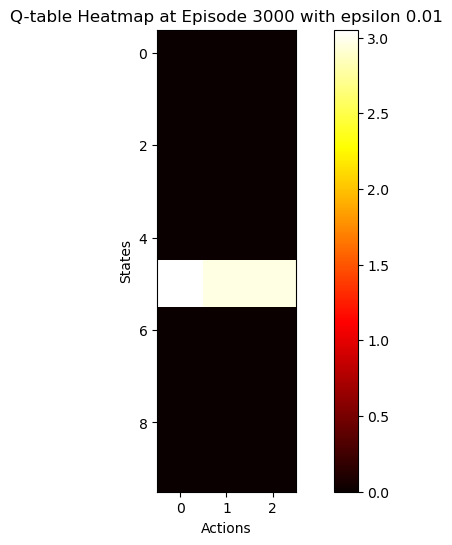

 40%|███▉      | 3990/10000 [00:30<00:42, 140.31it/s]

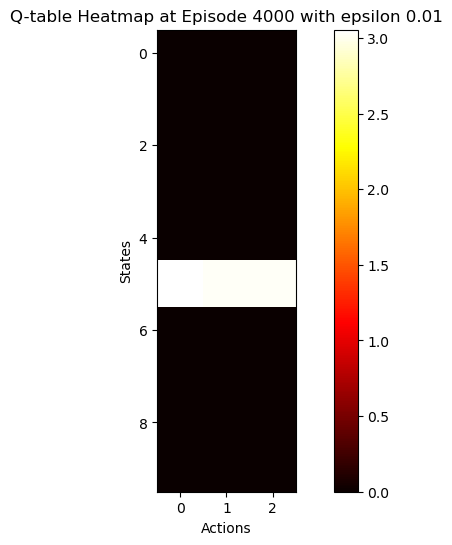

 50%|████▉     | 4994/10000 [00:37<00:34, 145.93it/s]

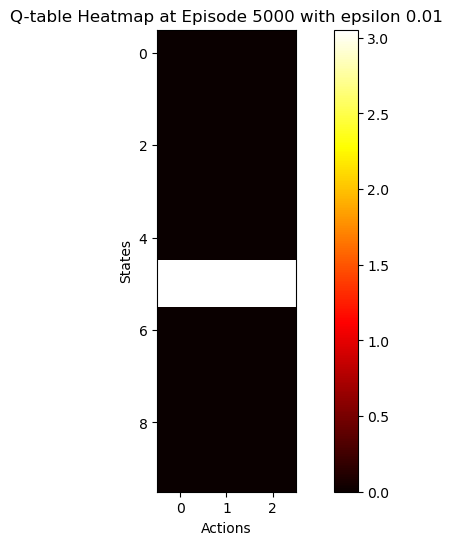

 60%|█████▉    | 5992/10000 [00:44<00:27, 148.07it/s]

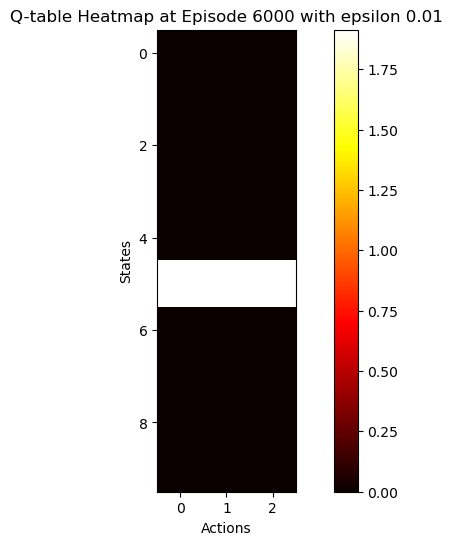

 70%|██████▉   | 6990/10000 [00:51<00:20, 150.45it/s]

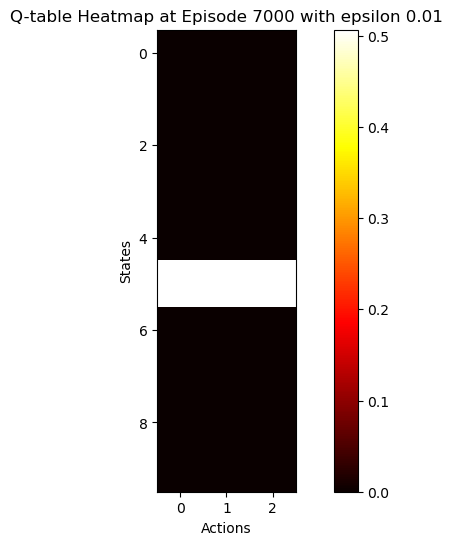

 80%|███████▉  | 7998/10000 [00:58<00:13, 146.75it/s]

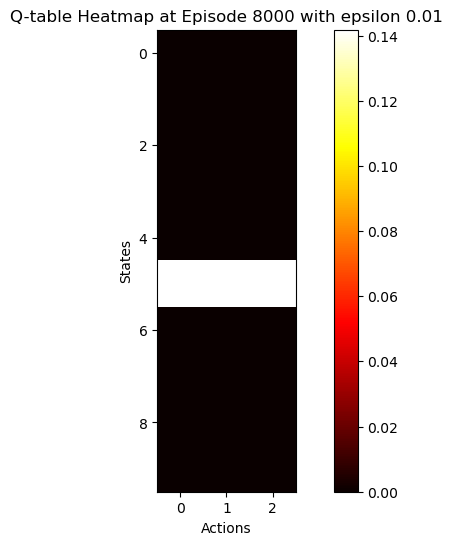

 90%|████████▉ | 8992/10000 [01:05<00:07, 137.60it/s]

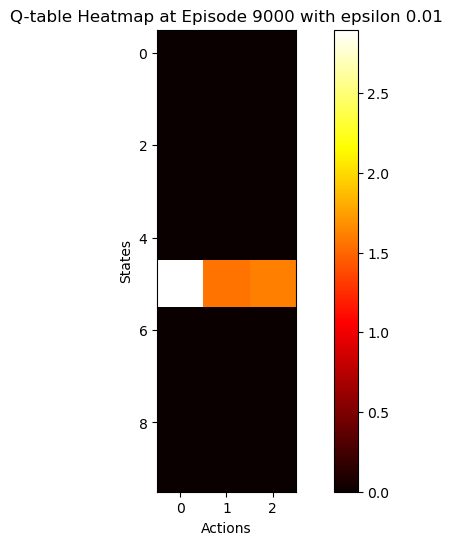

100%|█████████▉| 9988/10000 [01:12<00:00, 152.26it/s]

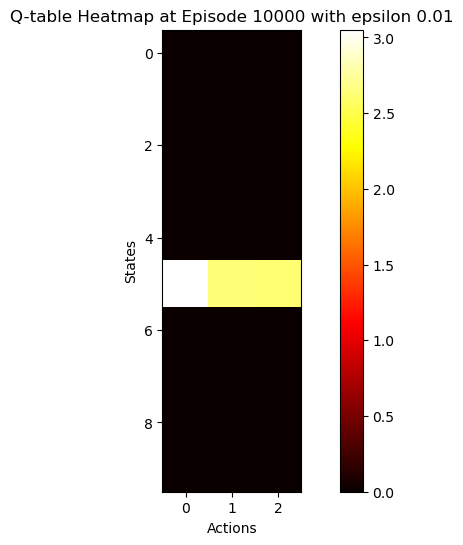

100%|██████████| 10000/10000 [01:15<00:00, 132.99it/s]


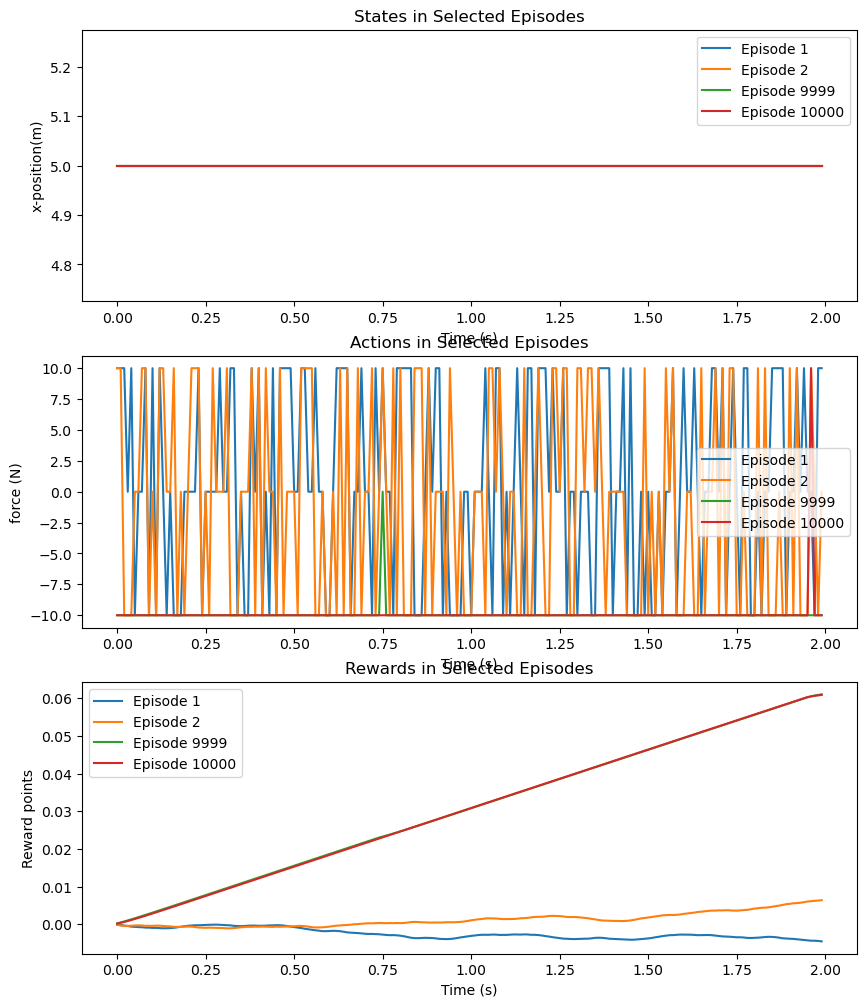

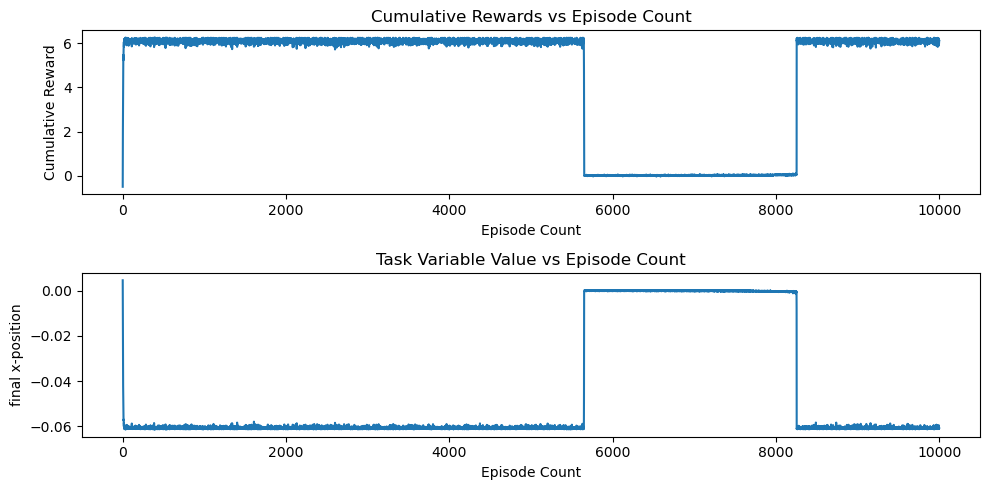

In [12]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 200#1000
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.8
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-10, 0, 10]  # Actions in the environment

# Initialize Q-table and epsilon
Q_table = np.zeros((10, len(ACTIONS)))  # 10 states, 3 actions
EPSILON = 1.0


# Define functions
def discretize_state(state_value):
    """Discretize the continuous state into 10 bins."""
    return int(np.digitize(state_value, np.linspace(-1, 1, 10)))

def choose_action(state):
    """Choose action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[state])  # Greedy action

def step_environment(model,data,action):
    """Step the environment and return next state, reward, done."""
    data.ctrl[0] = action  # Apply force as action
    mujoco.mj_step(model, data)  # Step simulation
    next_state = discretize_state(data.qpos[0])
    reward = -data.qpos[0]  # Task is to minimize distance from zero
    done = False
    return next_state, reward, done

def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(3, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("x-position(m)")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("force (N)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward points")
    plt.legend()
    plt.figure(figsize=(10, 5))
    # Plot for cumulative rewards
    plt.subplot(2, 1, 1)
    plt.title("Cumulative Rewards vs Episode Count")
    cumulative_rewards = [sum(episode) for episode in episode_rewards]
    plt.plot(range(len(cumulative_rewards)), cumulative_rewards)
    plt.xlabel("Episode Count")
    plt.ylabel("Cumulative Reward")

    # Plot for task variable values
    plt.subplot(2, 1, 2)
    plt.title("Task Variable Value vs Episode Count")
    plt.plot(range(len(task_variable_values)), task_variable_values)
    plt.xlabel("Episode Count")
    plt.ylabel("final x-position")

    plt.tight_layout()
    plt.show()

def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    # Rendering setup
    camera_name = "cam1"
    # Define the episodes to render
    requested_episodes = {0, 1, EPISODES-2, EPISODES-1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []  # Store rewards at each step
        # Reset environment
        data.qpos[0] = 0.0
        options = mujoco.MjvOption()
        mujoco.mjv_defaultOption(options)
        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []
        for step in range(EPISODE_LENGTH):
            state = discretize_state(data.qpos[0])
            action_idx = choose_action(state)
            action = ACTIONS[action_idx]

            next_state, reward, done = step_environment(model,data,action)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(state)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)
            # Q-learning update
            Q_table[state, action_idx] += LEARNING_RATE * (reward + GAMMA * np.max(Q_table[next_state]) - Q_table[state, action_idx])

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name,options)
                pixel = renderer.render()
                #frame=pixel
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode+1)}', (10, 30))  # Ensures episode is an integer
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))  # Time with 2 decimal places
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))  # Force with 2 decimal places
                # frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                video_frames.append(frame)
            

            if done:
                break
        
        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        # Store episode results
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qpos[0])  # Store final position of the mass

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)

if __name__ == "__main__":
    main()


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\rvign\AppData\Local\Temp\ipykernel_57792\1823537766.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.qpos[0] = qpos_spring  # Start from spring equilibrium
C:\Users\rvign\AppData\Local\Temp\ipykernel_57792\1823537766.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_idx = choose_action(int(spring_deviation))  # Use the spring deviation as the state
C:\Users\rvign\AppData\Local\Temp\ipykernel_57792\1823537766.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your

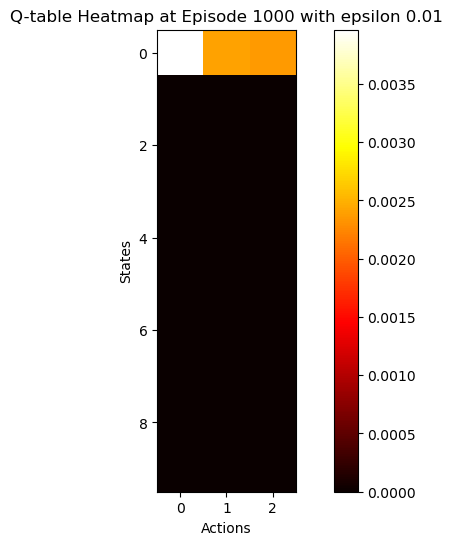

 20%|█▉        | 1995/10000 [00:19<00:57, 138.17it/s]

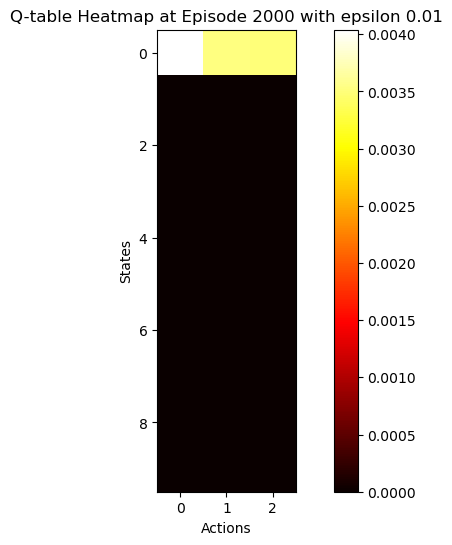

 30%|██▉       | 2995/10000 [00:27<00:49, 142.32it/s]

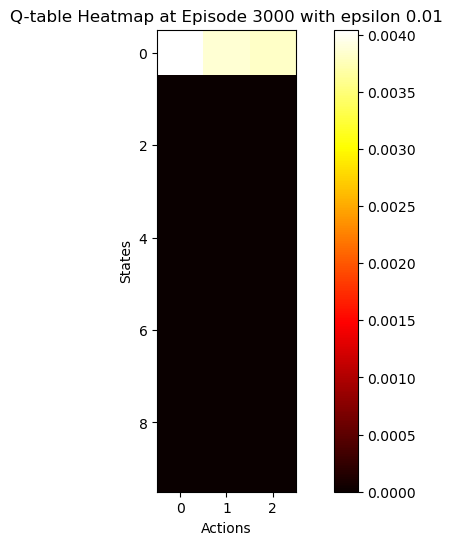

 40%|███▉      | 3998/10000 [00:35<00:46, 128.24it/s]

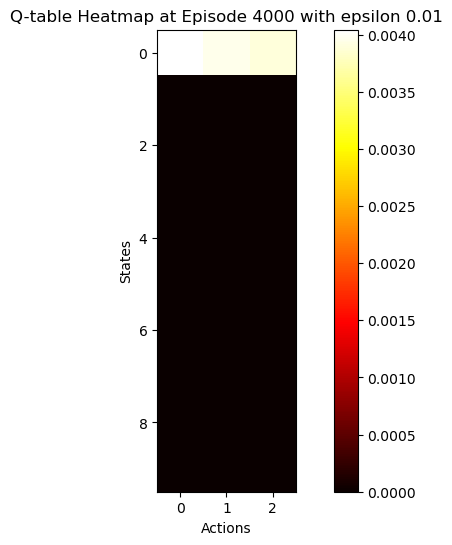

 50%|████▉     | 4988/10000 [00:42<00:36, 138.77it/s]

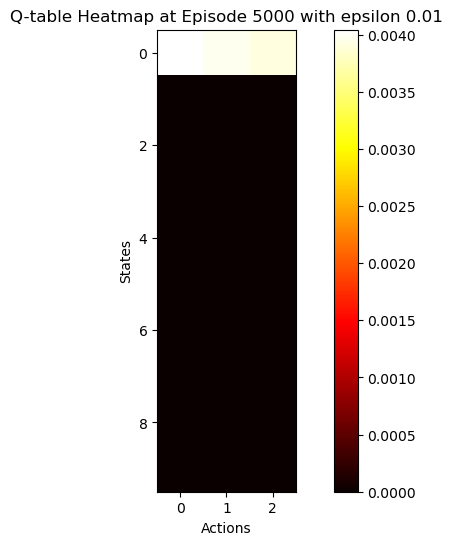

 60%|█████▉    | 5988/10000 [00:50<00:30, 130.75it/s]

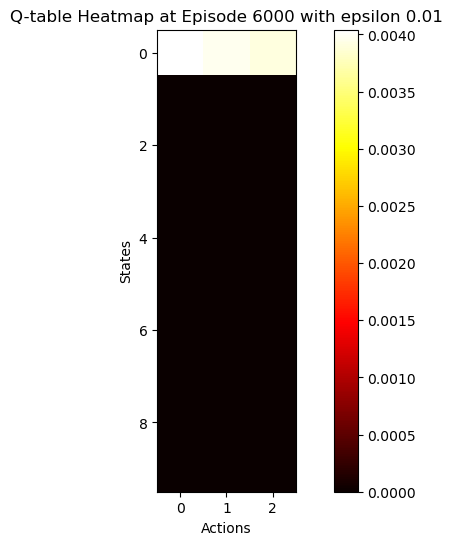

 70%|██████▉   | 6987/10000 [01:02<00:15, 194.38it/s]

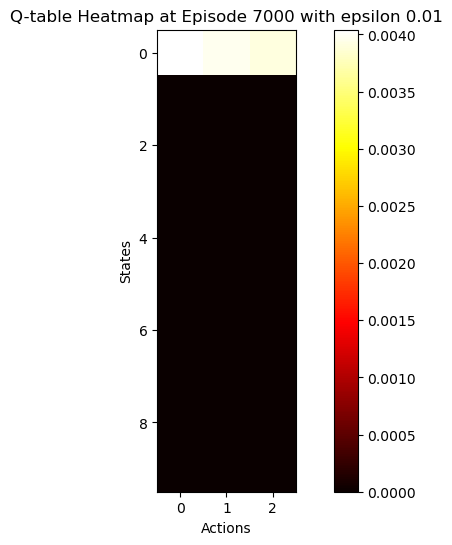

 80%|███████▉  | 7992/10000 [01:06<00:08, 233.28it/s]

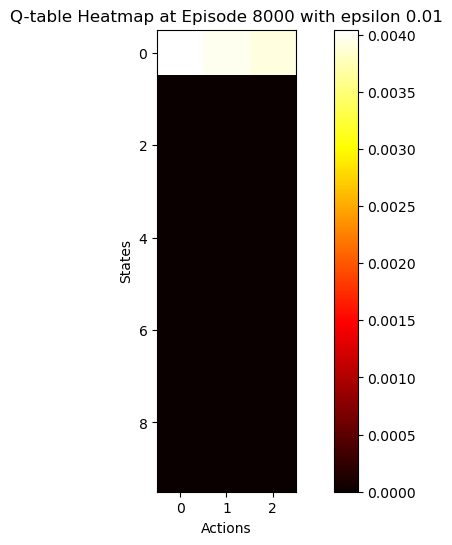

 90%|████████▉ | 8983/10000 [01:11<00:05, 198.81it/s]

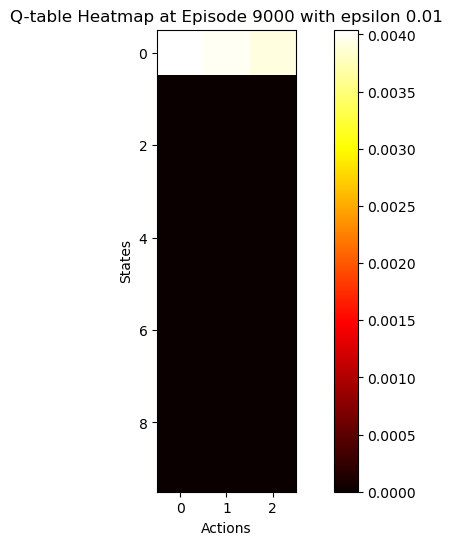

100%|█████████▉| 9995/10000 [01:16<00:00, 194.67it/s]

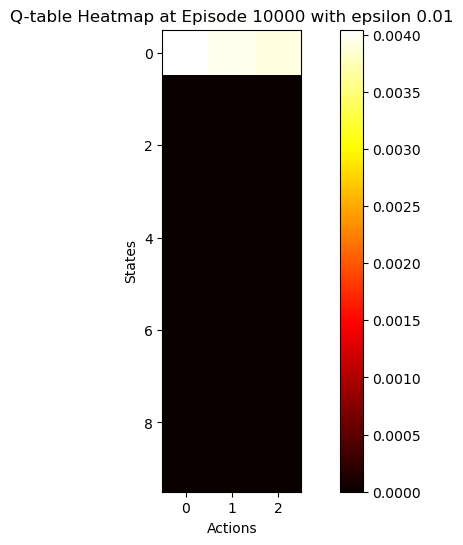

100%|██████████| 10000/10000 [01:19<00:00, 126.46it/s]


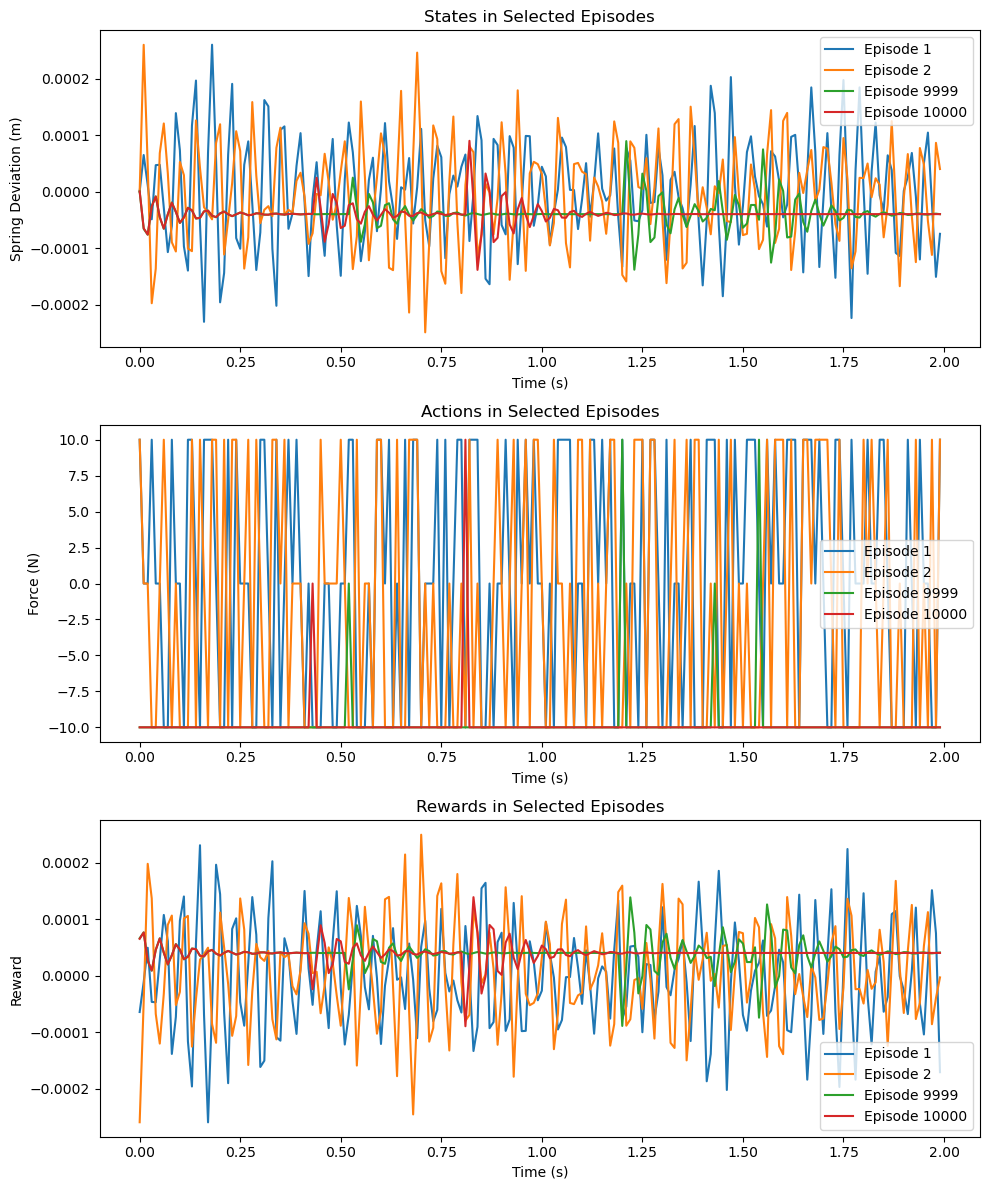

In [44]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 200
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.8
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-10, 0, 10]  # Actions in the environment

# Initialize Q-table and epsilon
Q_table = np.zeros((10, len(ACTIONS)))  # 10 states, 3 actions (for simplicity)
EPSILON = 1.0


# Define functions
def choose_action(state):
    """Choose action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[state])  # Greedy action

def step_environment(model, data, action, qpos_spring):
    """Step the environment and return next state, reward, done."""
    data.ctrl[0] = action  # Apply force as action
    mujoco.mj_step(model, data)  # Step simulation
    spring_deviation = data.qpos[0] - qpos_spring  # Deviation from equilibrium
    reward = -spring_deviation  # Minimize spring deviation
    done = False
    return spring_deviation, reward, done

def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(3, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Spring Deviation (m)")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Force (N)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward")
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Get the reference equilibrium position for the uncompressed spring
    qpos_spring = model.qpos_spring

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    camera_name = "cam1"
    requested_episodes = {0, 1, EPISODES - 2, EPISODES - 1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []  # Store rewards at each step
        data.qpos[0] = qpos_spring  # Start from spring equilibrium
        options = mujoco.MjvOption()
        mujoco.mjv_defaultOption(options)
        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []
        for step in range(EPISODE_LENGTH):
            spring_deviation = data.qpos[0] - qpos_spring
            action_idx = choose_action(int(spring_deviation))  # Use the spring deviation as the state
            action = ACTIONS[action_idx]

            next_spring_deviation, reward, done = step_environment(model, data, action, qpos_spring)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(spring_deviation)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)

            # Q-learning update
            Q_table[int(spring_deviation), action_idx] += LEARNING_RATE * (reward + GAMMA * np.max(Q_table[int(next_spring_deviation)]) - Q_table[int(spring_deviation), action_idx])

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name, options)
                pixel = renderer.render()
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode+1)}', (10, 30))
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))
                video_frames.append(frame)

            if done:
                break

        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qpos[0])  # Store final position of the mass

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)

if __name__ == "__main__":
    main()


In [43]:
import mujoco
import numpy as np
model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
model = mujoco.MjModel.from_xml_path(model_path)
data = mujoco.MjData(model)
print(model.qpos_spring) #For reference position for uncompressed spring

[0.1]


## Spring-mass with ball system
Maximize the ball velocity

In [13]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 1000
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.8
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-20, 0, 20]  # Force limits for ball movement along x-axis

# Initialize Q-table and epsilon
Q_table = np.zeros((2, len(ACTIONS)))  #2 states, 3 actions
EPSILON = 1.0


def choose_action(state):
    """Choose action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[state])  # Greedy action

def step_environment(model, data, action):
    """Step the environment and return next state, reward, done."""
    data.ctrl[0] = action  # Apply force to the ball along x-axis
    mujoco.mj_step(model, data)  # Step simulation

    # Discretize the ball's x-velocity as state
    next_state = data.qpos[1], data.qvel[1]  # position,velocity

    # Reward is proportional to the positive velocity of the ball along x-axis
    reward = data.qvel[1]  # Maximize velocity along x-axis

    # Check if the ball hits the wall or goes out of range
    done = data.qpos[1] >= 2.0 or data.qpos[1] <= -10.0
    return next_state, reward, done

def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(4, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode][0], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("ball position (m/s)")
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.title("States in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode][1], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("ball velocity (m/s)")
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("force (N)")
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward points")
    plt.legend()

    plt.figure(figsize=(10, 5))
    # Plot for cumulative rewards
    plt.subplot(2, 1, 1)
    plt.title("Cumulative Rewards vs Episode Count")
    cumulative_rewards = [sum(episode) for episode in episode_rewards]
    plt.plot(range(len(cumulative_rewards)), cumulative_rewards)
    plt.xlabel("Episode Count")
    plt.ylabel("Cumulative Reward")

    # Plot for task variable values
    plt.subplot(2, 1, 2)
    plt.title("Task Variable Value vs Episode Count")
    plt.plot(range(len(task_variable_values)), task_variable_values)
    plt.xlabel("Episode Count")
    plt.ylabel("Final x-velocity (m/s)")

    plt.tight_layout()
    plt.show()

def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springball.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    # Rendering setup
    camera_name = "cam1"
    # Define the episodes to render
    requested_episodes = {0, 1, EPISODES - 2, EPISODES - 1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []  # Store rewards at each step
        # Reset environment
        data.qpos[1] = 0.0  # Reset ball position
        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []
        
        for step in range(EPISODE_LENGTH):
            state = data.qpos[1], data.qvel[1]  # position, velocity
            action_idx = choose_action(state)
            action = ACTIONS[action_idx]

            next_state, reward, done = step_environment(model, data, action)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(state)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)
            # Q-learning update
            Q_table[state, action_idx] += LEARNING_RATE * (reward + GAMMA * np.max(Q_table[next_state]) - Q_table[state, action_idx])

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name, options)
                pixel = renderer.render()
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode + 1)}', (10, 30))
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))
                video_frames.append(frame)

            if done:
                break

        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qvel[1])  # Store final velocity of the ball

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)

if __name__ == "__main__":
    main()


  0%|          | 0/10000 [00:00<?, ?it/s]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices